In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r"C:\Users\Arin\OneDrive\Desktop\Projects\Cold Start Credit Scoring\application_record_modified.csv")
df.head()

,Unnamed: 0,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_YEARS,YEARS_EMPLOYED,risk_score,BAD_CLIENT
0,0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,...,1,1,0,0,NaN,2.0,32.9,12.4,0.1,0
1,1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,...,1,1,0,0,NaN,2.0,32.9,12.4,0.1,0
2,2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,...,1,0,0,0,Security staff,2.0,58.8,3.1,0.0,0
3,3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,...,1,0,1,1,Sales staff,1.0,52.4,8.4,0.0,0
4,4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,...,1,0,1,1,Sales staff,1.0,52.4,8.4,0.0,0


In [4]:
df_pp = df.drop(columns=["ID"])
df_pp["OCCUPATION_TYPE"] = df_pp["OCCUPATION_TYPE"].fillna("Unknown")

In [5]:
bin_map = {"Y":1,"N":0,"M":1,"F":0}
for col in ["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"]:
    df_pp[col] = df_pp[col].map(bin_map)

In [6]:
cat_cols = ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION_TYPE"]
df_encoded = pd.get_dummies(df_pp, columns=cat_cols, drop_first=True)

In [9]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 52 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         438557 non-null  int64  
 1   CODE_GENDER                                        438557 non-null  int64  
 2   FLAG_OWN_CAR                                       438557 non-null  int64  
 3   FLAG_OWN_REALTY                                    438557 non-null  int64  
 4   CNT_CHILDREN                                       438557 non-null  int64  
 5   AMT_INCOME_TOTAL                                   438557 non-null  float64
 6   DAYS_BIRTH                                         438557 non-null  int64  
 7   DAYS_EMPLOYED                                      438557 non-null  int64  
 8   FLAG_MOBIL                                         438557 non-null  int64 

In [7]:
X = df_encoded.drop(columns=['BAD_CLIENT'])
y = df_encoded['BAD_CLIENT']

print("Shape of X:", X.shape)
print("Number of bad clients:", y.sum())

Shape of X: (438557, 51)
Number of bad clients: 5699


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,
                                                stratify=y,random_state=42)
lr = LogisticRegression(max_iter=1000,class_weight="balanced",solver="liblinear")
lr.fit(X_train,y_train)
y_pred  = lr.predict(X_test)
y_prob  = lr.predict_proba(X_test)[:,1]

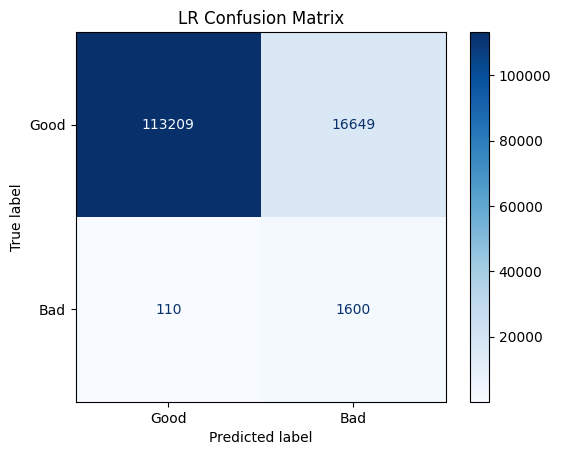

              precision    recall  f1-score   support

           0     0.9990    0.8718    0.9311    129858
           1     0.0877    0.9357    0.1603      1710

    accuracy                         0.8726    131568
   macro avg     0.5434    0.9037    0.5457    131568
weighted avg     0.9872    0.8726    0.9211    131568

ROC AUC: 0.957


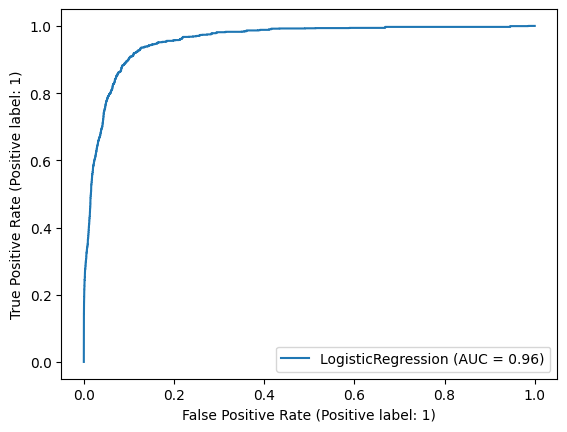

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),
                       display_labels=["Good","Bad"]).plot(cmap="Blues")
plt.title("LR Confusion Matrix"); plt.show()
print(classification_report(y_test,y_pred,digits=4))
print("ROC AUC:", roc_auc_score(y_test,y_prob).round(4))
RocCurveDisplay.from_estimator(lr,X_test,y_test); plt.show()

# Tree Modelling & Leakage Control

In [ ]:
'''
risk score definition:
df["risk_score"] = (
    (df["AMT_INCOME_TOTAL"] < 50000).astype(int) * 0.3 +
    (df["CNT_CHILDREN"]    >= 3).astype(int)     * 0.2 +
    (df["AGE_YEARS"]       > 60).astype(int)     * 0.2 +
    (df["CNT_FAM_MEMBERS"] > 6).astype(int)      * 0.2 +
    (df["OCCUPATION_TYPE"].isna() &
     ~df["NAME_INCOME_TYPE"].isin(["Pensioner","Student"])).astype(int)*0.1
)
'''

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

X_leak = X.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X_leak, y, test_size=0.3, stratify=y, random_state=42
)
spw = (y_train == 0).sum() / (y_train == 1).sum()

xgb_leak = XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    scale_pos_weight=spw, random_state=42,
    use_label_encoder=False, eval_metric="logloss"
)
xgb_leak.fit(X_train, y_train)
y_pred_leak  = xgb_leak.predict(X_test)
y_prob_leak  = xgb_leak.predict_proba(X_test)[:, 1]

print("Leakage Metrics (expect 1.0 AUC):")
print(classification_report(y_test, y_pred_leak, digits=4))
print("ROC AUC :", roc_auc_score(y_test, y_prob_leak).round(4))

Leakage Metrics (expect 1.0 AUC):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    129858
           1     1.0000    1.0000    1.0000      1710

    accuracy                         1.0000    131568
   macro avg     1.0000    1.0000    1.0000    131568
weighted avg     1.0000    1.0000    1.0000    131568

ROC AUC : 1.0


In [14]:
# XGB Leakage fixed

X_noleak = X.drop(columns=["risk_score"])
X_train, X_test, y_train, y_test = train_test_split(
    X_noleak, y, test_size=0.3, stratify=y, random_state=42
)
spw = (y_train == 0).sum() / (y_train == 1).sum()

xgb_noleak = XGBClassifier(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    scale_pos_weight=spw, random_state=42,
    use_label_encoder=False, eval_metric="logloss"
)
xgb_noleak.fit(X_train, y_train)
y_pred_noleak = xgb_noleak.predict(X_test)
y_prob_noleak = xgb_noleak.predict_proba(X_test)[:, 1]

print("No-Leak Metrics:")
print(classification_report(y_test, y_pred_noleak, digits=4))
print("ROC AUC :", roc_auc_score(y_test, y_prob_noleak).round(4))

No-Leak Metrics:
              precision    recall  f1-score   support

           0     1.0000    0.9996    0.9998    129858
           1     0.9732    1.0000    0.9864      1710

    accuracy                         0.9996    131568
   macro avg     0.9866    0.9998    0.9931    131568
weighted avg     0.9997    0.9996    0.9996    131568

ROC AUC : 1.0


In [15]:
xgb_final = xgb_noleak

<Figure size 800x600 with 0 Axes>

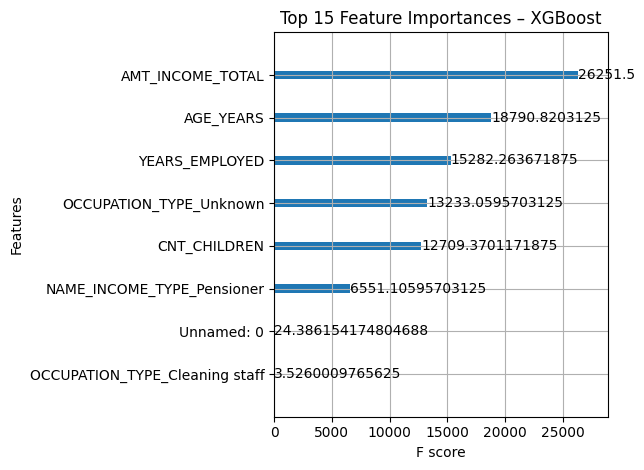

Fold,ROC_AUC
1,0.999800
2,0.999900
3,0.999800
4,0.999800
5,0.999800
Mean,0.999800


In [16]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

drop_cols = ["risk_score", "DAYS_BIRTH", "DAYS_EMPLOYED"]
X_refined = X.drop(columns=[c for c in drop_cols if c in X.columns])

X_train, X_test, y_train, y_test = train_test_split(
    X_refined, y, test_size=0.3, stratify=y, random_state=42
)

spw = (y_train == 0).sum() / (y_train == 1).sum()

xgb_final = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=spw,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)
xgb_final.fit(X_train, y_train)

plt.figure(figsize=(8, 6))
plot_importance(xgb_final, max_num_features=15, importance_type="gain")
plt.title("Top 15 Feature Importances – XGBoost")
plt.tight_layout()
plt.show()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_final, X_refined, y, cv=cv, scoring="roc_auc")

cv_df = pd.DataFrame({"Fold": range(1, 6), "ROC_AUC": cv_scores.round(4)})
cv_df.loc[len(cv_df)] = ["Mean", round(cv_scores.mean(), 4)]
display(cv_df.style.hide_index())


## Precision-Recall Threshold Tuning

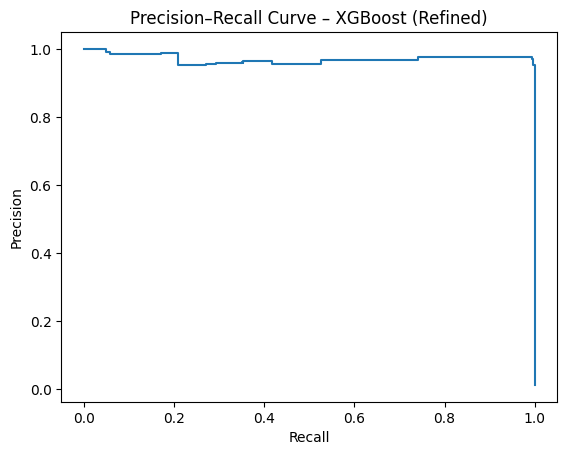


  Threshold = 0.30
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997    129858
           1     0.9532    1.0000    0.9760      1710

    accuracy                         0.9994    131568
   macro avg     0.9766    0.9997    0.9879    131568
weighted avg     0.9994    0.9994    0.9994    131568


  Threshold = 0.70
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997    129858
           1     0.9530    0.9965    0.9743      1710

    accuracy                         0.9993    131568
   macro avg     0.9765    0.9979    0.9870    131568
weighted avg     0.9993    0.9993    0.9993    131568



In [19]:
from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report,
)

y_prob_final = xgb_final.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_prob_final)
PrecisionRecallDisplay(precision=prec, recall=rec).plot()
plt.title("Precision–Recall Curve – XGBoost (Refined)")
plt.show()

for t in [0.30, 0.70]:
    print(f"\n  Threshold = {t:.2f}")
    preds = (y_prob_final > t).astype(int)
    print(classification_report(y_test, preds, digits=4))